In [1]:
from astropy.io import fits
import astroalign as aa
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from scipy.ndimage import gaussian_filter
from photutils.profiles import RadialProfile

c:\Users\simon\anaconda3\envs\astro_ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
fits_file = 'M41_Lab1.fits'
fits.info(fits_file)

Filename: M41_Lab1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      35   (3096, 2080)   float64   
  1                1 ImageHDU        36   (3096, 2080)   float64   
  2                1 ImageHDU        36   (3096, 2080)   float64   


In [3]:
fits.getheader(fits_file, ext=2)
#Tiempo de exposicion real es 25s. Son stacks de 5 imágenes de 5 segundos.

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 3096                                                  
NAXIS2  =                 2080                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
DATE-OBS= '2026-02-14T03:32:22.892' / UTC start date of observation             
EXPTIME =                   5. / Total Exposure Time (s)                        
EXPOINUS=              5000000 / Exposure time in us                            
INSTRUME= 'ZWO ASI178MM'       / Camera model                                   
SWCREATE= 'ASIImg  '           / Name of software that created the image        
SWOWNER = 'ZWO     '        

Text(0.5, 1.0, 'M41 Cluster - FITS Image')

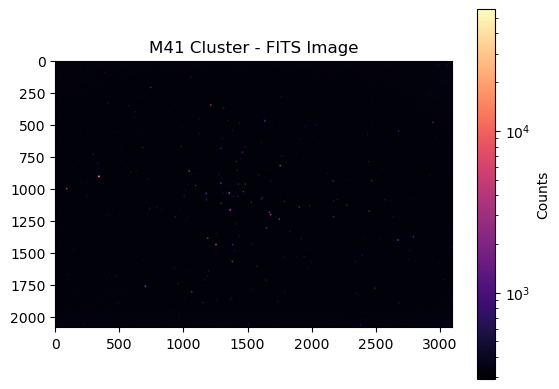

In [4]:
array = fits.getdata(fits_file, ext=2)
filtered = gaussian_filter(array,sigma=2)
plt.imshow(filtered, cmap='magma', norm='log')
plt.colorbar(label='Counts')
plt.title('M41 Cluster - FITS Image')

Background mean = 326.63188187950857
Background std  = 21.15307785444878


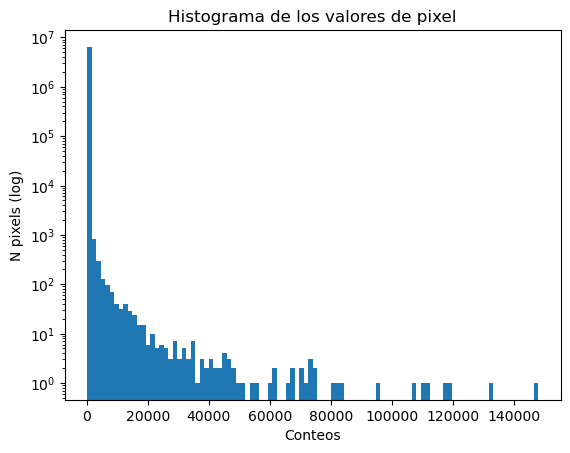

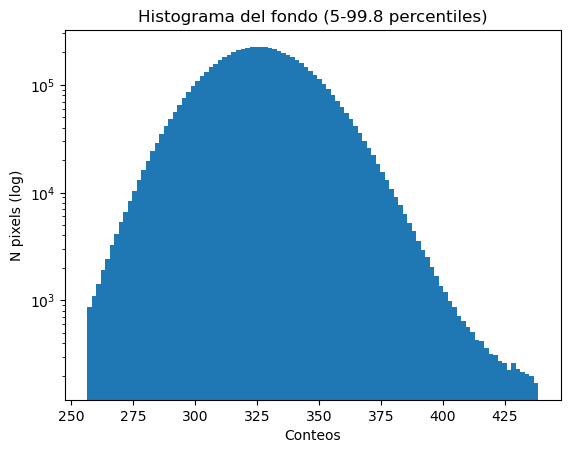

In [5]:
vals = array.ravel()
plt.hist(vals, bins=100, log=True)
plt.title("Histograma de los valores de pixel")
plt.xlabel("Conteos")
plt.ylabel("N pixels (log)")
low, high = np.percentile(vals, [0.05, 99.8])
bkg_vals = vals[(vals > low) & (vals < high)]

bkg_mean = np.mean(bkg_vals)
bkg_std  = np.std(bkg_vals)

print(f"Background mean = {bkg_mean}")
print(f"Background std  = {bkg_std}")
plt.figure()
plt.hist(bkg_vals, bins=100, log=True)
plt.title("Histograma del fondo (5-99.8 percentiles)")
plt.xlabel("Conteos")
plt.ylabel("N pixels (log)")
plt.show()



In [6]:
threshold_sigma = bkg_mean + 3*bkg_std
print(f"Threshold sigma = {threshold_sigma}")

Threshold sigma = 390.0911154428549


Estrellas brillantes detectadas: 406


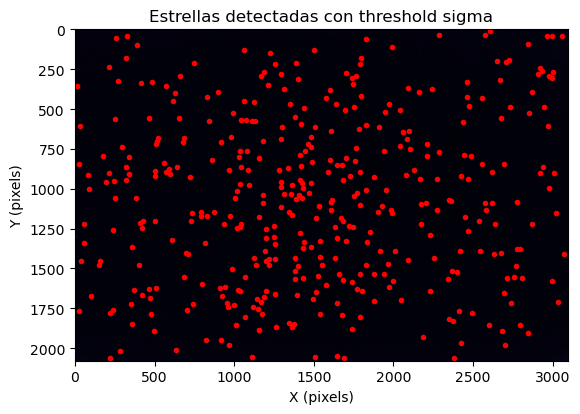

In [7]:
#Estrellas con threshold Sigma:
#Los centros:
coordinates = peak_local_max(filtered, threshold_abs=threshold_sigma, min_distance=10)
print(f"Estrellas brillantes detectadas: {len(coordinates)}")
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.imshow(filtered, cmap='magma', norm='log')
plt.title('Estrellas detectadas con threshold sigma')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')

Estrellas brillantes detectadas en regiones homogéneas: 36


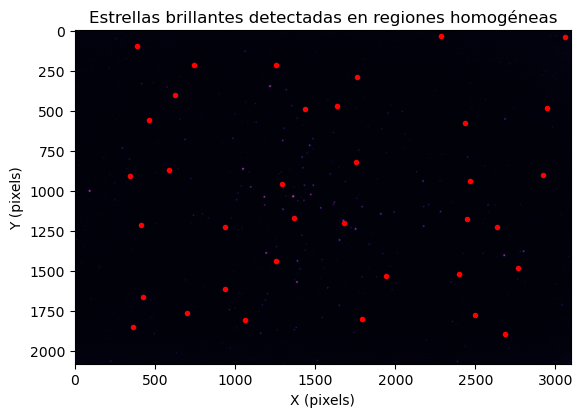

In [8]:
#Las 30 estrellas más brillantes:
# Dividir la imagen en n x n regiones y obtener coordenadas globales
n = 6  # Número de divisiones por lado
h, w = filtered.shape
sub_h, sub_w = h // n, w // n

coord_estrellas_brillantes_global = []
for i in range(n):
    for j in range(n):
        region = filtered[i*sub_h:(i+1)*sub_h, j*sub_w:(j+1)*sub_w]
        coords_region = peak_local_max(region, threshold_abs=threshold_sigma, min_distance=30)
        if len(coords_region) > 0:
            estrella = coords_region
            estrella_mas_brillante = np.argmax(region[estrella[:, 0], estrella[:, 1]])
            coord_local = estrella[estrella_mas_brillante]
            # Convertir a coordenadas globales
            coord_global = (coord_local[0] + i*sub_h, coord_local[1] + j*sub_w)
            coord_estrellas_brillantes_global.append(coord_global)
print(f"Estrellas brillantes detectadas en regiones homogéneas: {len(coord_estrellas_brillantes_global)}")
coord_global = np.array(coord_estrellas_brillantes_global)
plt.figure()
plt.imshow(filtered, cmap='magma', norm='log')
plt.title('Estrellas brillantes detectadas en regiones homogéneas')
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.plot(coord_global[:, 1], coord_global[:, 0], 'r.')

In [9]:
#Cálculo del perfil radial de las estrellas mas brillantes:

perfil_radial = []
fwhm = []
for coord in coord_global:
    xycen = (float(coord[1]), float(coord[0]))  # (x, y)
    rp = RadialProfile(filtered, xycen=xycen, radii=np.arange(10))
    fwhm.append(rp.gaussian_fwhm)
    perfil_radial.append(rp.profile)
print(len(fwhm))
#Estadísticas de FWHM
fwhm = np.array(fwhm)
print(f"FWHM media: {np.mean(fwhm):.2f} pixels")
print(f"FWHM mediana: {np.median(fwhm):.2f} pixels")
print(f"FWHM std: {np.std(fwhm):.2f} pixels")

#Tomamos entonces que el valor de FWM en la imagen es:
fwhm_imagen = np.median(fwhm)
print(f"FWHM de la imagen: {fwhm_imagen:.2f} pixels")

36
FWHM media: 11.44 pixels
FWHM mediana: 10.84 pixels
FWHM std: 5.24 pixels
FWHM de la imagen: 10.84 pixels


In [32]:
#EL codigo anterior sirve para evaluar solo la imagen blue, automaticemos para cualquier imagen:
#Las imágenes están desalineadas, usamos astroalign para alinearlas antes de hacer el análisis:
def alinear_imagenes(fits_file, ext_ref, ext_to_align):
    reference = fits.getdata(fits_file, ext=ext_ref).astype(np.float32)
    to_align = fits.getdata(fits_file, ext=ext_to_align).astype(np.float32)
    aligned,_ = aa.register(to_align, reference)
    return aligned
def calcular_threshold_sigma(array):
    vals = array.ravel()
    low, high = np.percentile(vals, [0.05, 99.8])
    bkg_vals = vals[(vals > low) & (vals < high)]
    bkg_mean = np.mean(bkg_vals)
    bkg_std  = np.std(bkg_vals)
    threshold_sigma = bkg_mean + 3*bkg_std
    print(f"Threshold sigma = {threshold_sigma}")
    return threshold_sigma

def detectar_estrellas(array, threshold_sigma):
    filtered = gaussian_filter(array,sigma=2)
    coordinates = peak_local_max(filtered, threshold_abs=threshold_sigma, min_distance=10)
    print(f"Estrellas brillantes detectadas: {len(coordinates)}")
    plt.figure(figsize=(14, 8))
    plt.imshow(filtered, cmap='magma', norm='log')
    plt.title('Estrellas detectadas con threshold sigma')
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.plot(coordinates[:, 1], coordinates[:, 0], 'r.')
    return coordinates

def estrellas_30(filtered): 
    n = 6  # Número de divisiones por lado
    h, w = filtered.shape
    sub_h, sub_w = h // n, w // n

    coord_estrellas_brillantes_global = []
    for i in range(n):
        for j in range(n):
            region = filtered[i*sub_h:(i+1)*sub_h, j*sub_w:(j+1)*sub_w]
            coords_region = peak_local_max(region, threshold_abs=threshold_sigma, min_distance=30)
            if len(coords_region) > 0:
                estrella = coords_region
                estrella_mas_brillante = np.argmax(region[estrella[:, 0], estrella[:, 1]])
                coord_local = estrella[estrella_mas_brillante]
                # Convertir a coordenadas globales
                coord_global = (coord_local[0] + i*sub_h, coord_local[1] + j*sub_w)
                coord_estrellas_brillantes_global.append(coord_global)
    print(f"Estrellas brillantes detectadas en regiones homogéneas: {len(coord_estrellas_brillantes_global)}")
    coord_global = np.array(coord_estrellas_brillantes_global)
    plt.figure()
    plt.imshow(filtered, cmap='magma', norm='log')
    plt.title('Estrellas brillantes detectadas en regiones homogéneas')
    plt.xlabel('X (pixels)')
    plt.ylabel('Y (pixels)')
    plt.plot(coord_global[:, 1], coord_global[:, 0], 'r.')
    return coord_global

def calcular_fwhm(coordinates, filtered):
    perfil_radial = []
    fwhm = []
    for coord in coordinates:
        xycen = (float(coord[1]), float(coord[0]))  # (x, y)
        rp = RadialProfile(filtered, xycen=xycen, radii=np.arange(10))
        fwhm.append(rp.gaussian_fwhm)
        perfil_radial.append(rp.profile)
    #Estadísticas de FWHM
    fwhm = np.array(fwhm)
    print(f"FWHM media: {np.mean(fwhm):.2f} pixels")
    print(f"FWHM mediana: {np.median(fwhm):.2f} pixels")
    print(f"FWHM std: {np.std(fwhm):.2f} pixels")

    #Tomamos entonces que el valor de FWM en la imagen es:
    fwhm_imagen = np.median(fwhm)
    print(f"FWHM de la imagen: {fwhm_imagen:.2f} pixels")
    return fwhm_imagen

#Fotometría de apertura:
def fotometria_apertura(coord, img, fwhm_imagen):
    r1 = 3 * fwhm_imagen
    r2 = 4 * fwhm_imagen
    r3 = 5 * fwhm_imagen
    y, x = np.indices(img.shape)
    aperture_mask = (x - coord[1])**2 + (y - coord[0])**2 <= r1**2
    flux_apertura = np.sum(img[aperture_mask])
    n_pix_apertura = np.sum(aperture_mask)
    annulus_mask = ((x - coord[1])**2 + (y - coord[0])**2 >= r2**2) & ((x - coord[1])**2 + (y - coord[0])**2 <= r3**2)
    flux_anillo = np.sum(img[annulus_mask])
    n_pix_anillo = np.sum(annulus_mask)
    fondo_por_pixel = flux_anillo / n_pix_anillo
    correccion_fondo = fondo_por_pixel * n_pix_apertura
    flujo_neto = flux_apertura - correccion_fondo
    return flujo_neto/25  # Dividir por el tiempo de exposición real (25s)

def magnitud(flujo):
    return -2.5 * np.log10(flujo+1e-10)  # Agregar un pequeño valor para evitar log(0)

def color(m1, m2):
    return m1 - m2

Filtro azul:
Threshold sigma = 402.0518493652344
Estrellas brillantes detectadas: 377
Estrellas brillantes detectadas en regiones homogéneas: 36
FWHM media: 11.40 pixels
FWHM mediana: 9.83 pixels
FWHM std: 4.92 pixels
FWHM de la imagen: 9.83 pixels


C:\Users\simon\AppData\Local\Temp\ipykernel_44096\1494418078.py:92: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flujo+1e-10)  # Agregar un pequeño valor para evitar log(0)


[np.float64(-13.525254993200019), np.float64(-11.648210556573568), np.float64(-11.484486272646809), np.float64(-12.046569540744299), np.float64(-11.112366824511053), np.float64(-11.174681445097196), np.float64(-11.099970108613025), np.float64(-10.820231722761992), np.float64(-10.834584436554895), np.float64(-11.099445209641027), np.float64(-10.933508074728199), np.float64(-12.041760870668568), np.float64(-10.625769740765985), np.float64(-10.775093828354143), np.float64(-10.990145440835805), np.float64(-10.778800383498155), np.float64(-10.653616117762274), np.float64(-10.490499279887382), np.float64(-10.253292037232065), np.float64(-10.499020131589434), np.float64(-10.354339105298752), np.float64(-10.314741435273678), np.float64(-10.419353261069212), np.float64(-10.016077471375215), np.float64(-10.128555720905712), np.float64(-10.205526709124971), np.float64(-10.13246789853968), np.float64(-10.163607628441989), np.float64(-10.070900648848532), np.float64(-10.02774145881629), np.float64(

C:\Users\simon\AppData\Local\Temp\ipykernel_44096\1494418078.py:92: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flujo+1e-10)  # Agregar un pequeño valor para evitar log(0)


[np.float64(-12.44748538097416), np.float64(-12.460014990505401), np.float64(-11.746667618909418), np.float64(-11.696616060144319), np.float64(-11.43313014453309), np.float64(-11.440216381305534), np.float64(-11.358043741013956), np.float64(-11.333221373502369), np.float64(-11.169155306223356), np.float64(-11.110606437965956), np.float64(-11.137556094125774), np.float64(-10.681662981141207), np.float64(-10.364259526430908), np.float64(-10.202698721171032), np.float64(-10.116976931582435), np.float64(-10.134541262939944), np.float64(-10.074772762317611), np.float64(-11.15040253409422), np.float64(-9.861144422693734), np.float64(-9.824847821133622), np.float64(-9.75215635851358), np.float64(-9.610894432938272), np.float64(-9.624052837584964), np.float64(-9.435159484692187), np.float64(-9.449880050602378), np.float64(-9.380221248567105), np.float64(-9.275606275591032), np.float64(-9.18176770257609), np.float64(-9.4965974597327), np.float64(-9.274254313028875), np.float64(-9.28161539426590

C:\Users\simon\AppData\Local\Temp\ipykernel_44096\1494418078.py:92: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flujo+1e-10)  # Agregar un pequeño valor para evitar log(0)


[np.float64(-12.502617507389967), np.float64(-11.424178586397398), np.float64(-11.129077403442336), np.float64(-10.915006090128156), np.float64(-11.12813326210672), np.float64(-10.608627925987031), np.float64(-10.599905674128712), np.float64(-10.487942536010697), np.float64(-10.560035924532729), np.float64(-10.279480358412844), np.float64(-10.440700273683463), np.float64(-10.16739037887483), np.float64(-10.170409951688374), np.float64(-10.1588907146057), np.float64(-9.960277105514521), np.float64(-11.163462795239676), np.float64(-10.087825312801417), np.float64(-9.684585331262971), np.float64(-9.578851754474757), np.float64(-9.563491200530658), np.float64(-9.780610466577247), np.float64(-9.421417029833751), np.float64(-9.361381116886513), np.float64(-9.488447915978803), np.float64(-8.936458081059463), np.float64(-9.243783584152212), np.float64(-9.313279346010376), np.float64(-9.307053645910726), np.float64(-9.135018056101522), np.float64(-9.054445075373863), np.float64(-9.1285361196266

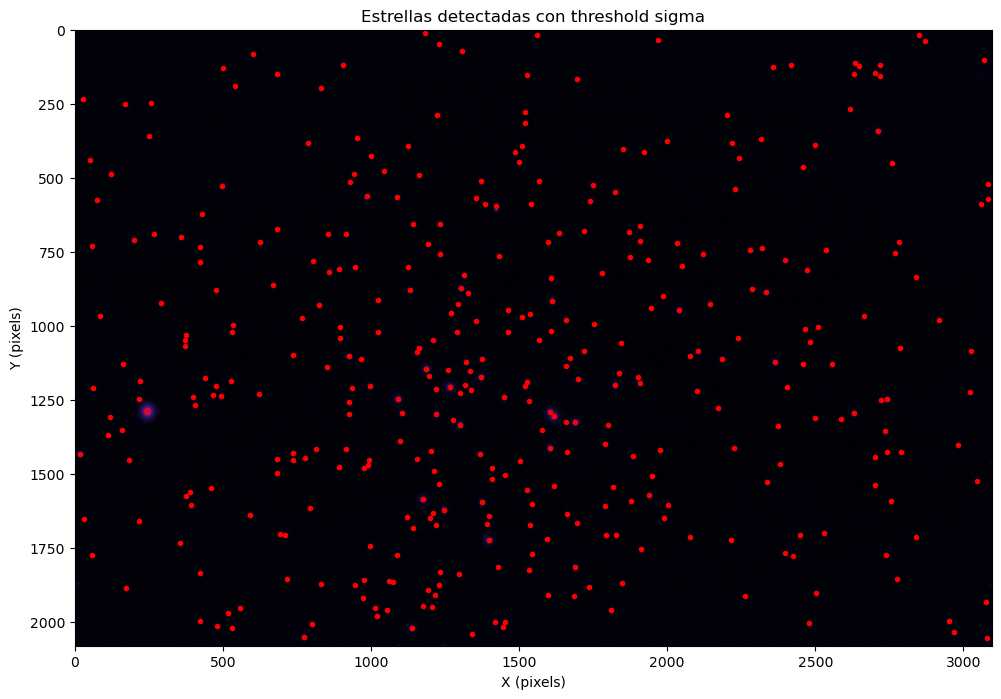

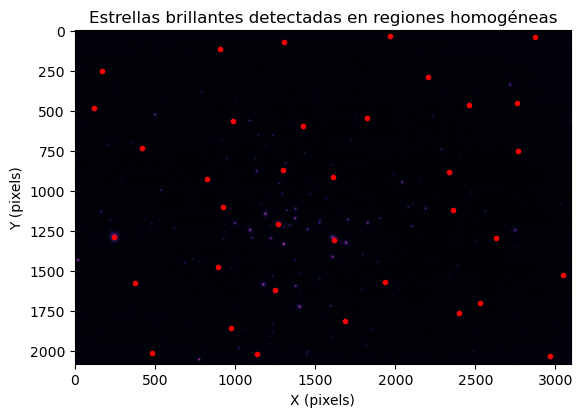

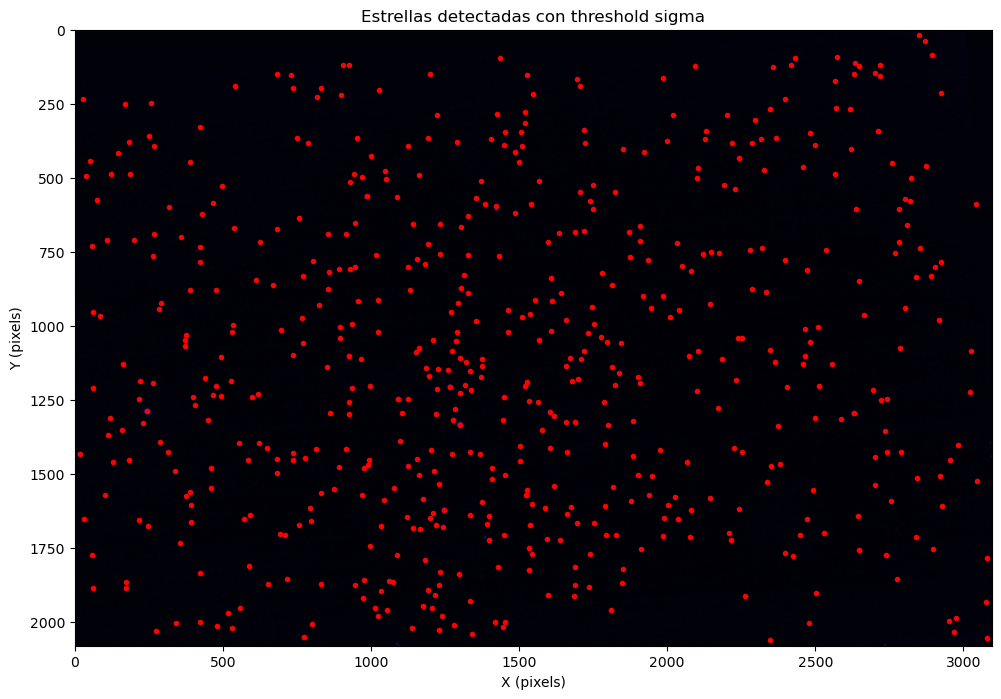

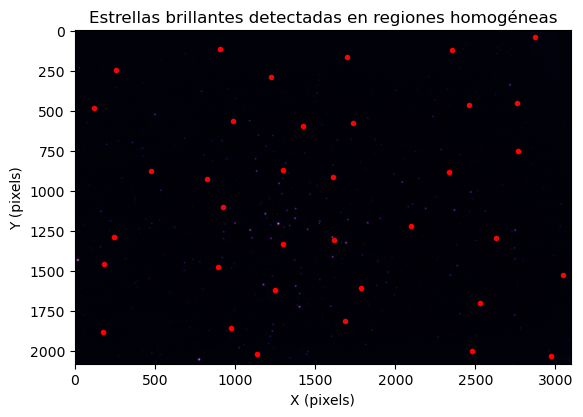

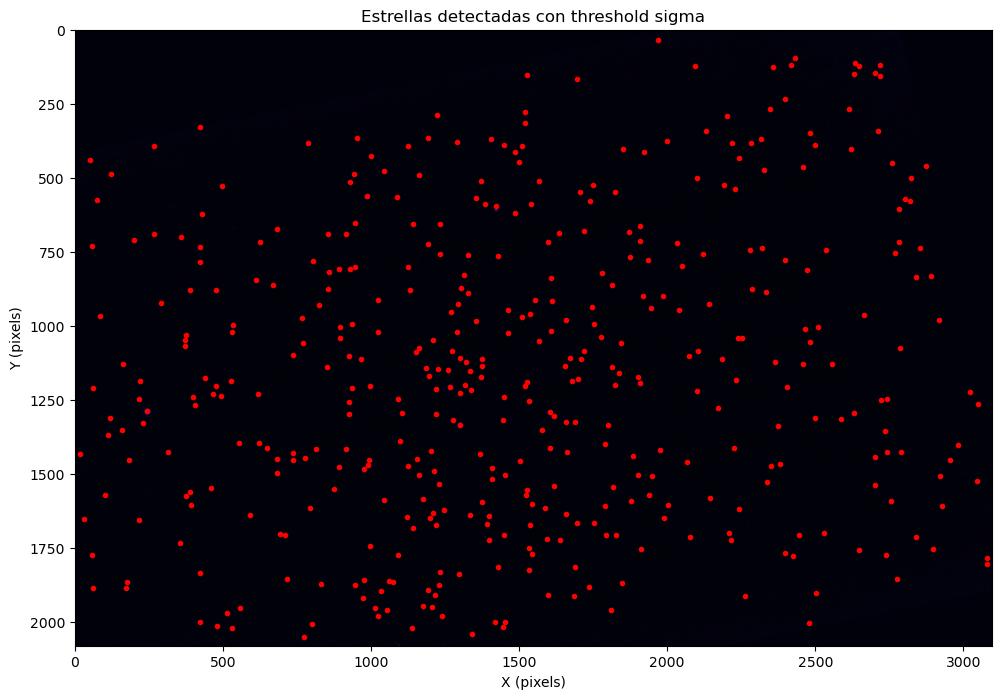

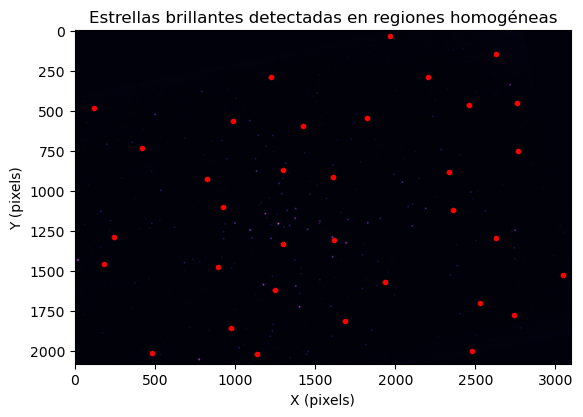

In [13]:
#Pruebas:  
#Definamos Azul como la imagen referencia:
ext_ref = 0
azul = fits.getdata(fits_file, ext=ext_ref).astype(np.float32)
rojo = alinear_imagenes(fits_file, ext_ref, 1)
verde = alinear_imagenes(fits_file, ext_ref, 2)
#Filtro azul:
print("Filtro azul:")
threshold_sigma_azul = calcular_threshold_sigma(azul)
coordinates_azul = detectar_estrellas(azul, threshold_sigma_azul)
filtered_azul = gaussian_filter(azul, sigma=2)
coord_global_azul = estrellas_30(filtered_azul)
fwhm_imagen_azul = calcular_fwhm(coord_global_azul, filtered_azul)
flujos_netos_azul = [fotometria_apertura(coord, filtered_azul, fwhm_imagen_azul) for coord in coordinates_azul]
magnitudes_azul = [magnitud(flujo) for flujo in flujos_netos_azul]
print(magnitudes_azul)

#Filtro rojo:
print("Filtro rojo:")
threshold_sigma_rojo = calcular_threshold_sigma(rojo)
coordinates_rojo = detectar_estrellas(rojo, threshold_sigma_rojo)
filtered_rojo = gaussian_filter(rojo, sigma=2)
coord_global_rojo = estrellas_30(filtered_rojo)
fwhm_imagen_rojo = calcular_fwhm(coord_global_rojo, filtered_rojo)
flujos_netos_rojo = [fotometria_apertura(coord, filtered_rojo, fwhm_imagen_rojo) for coord in coordinates_rojo]
magnitudes_rojo = [magnitud(flujo) for flujo in flujos_netos_rojo]
print(magnitudes_rojo)

#Filtro verde:
print("Filtro verde:")
threshold_sigma_verde = calcular_threshold_sigma(verde)
coordinates_verde = detectar_estrellas(verde, threshold_sigma_verde)
filtered_verde = gaussian_filter(verde, sigma=2)
coord_global_verde = estrellas_30(filtered_verde)
fwhm_imagen_verde = calcular_fwhm(coord_global_verde, filtered_verde)
flujos_netos_verde = [fotometria_apertura(coord, filtered_verde, fwhm_imagen_verde) for coord in coordinates_verde]
magnitudes_verde = [magnitud(flujo) for flujo in flujos_netos_verde]
print(magnitudes_verde)


In [33]:
#Problema: No todos los filtros tienen la misma cantidad de estrellas:
from scipy.spatial import cKDTree
def crossmatch(im1, im2, r_max=2.0):
    tree = cKDTree(im2)
    dist, idx = tree.query(im1, distance_upper_bound=r_max)

    # matches válidos
    mask = np.isfinite(dist)

    ref_matched   = im1[mask]
    other_matched = im2[idx[mask]]

    return ref_matched, other_matched, mask

azul_r, rojo_m, mask_ar = crossmatch(
    coordinates_azul,
    coordinates_rojo,
    r_max=2.0
)
azul_g, verde_m, mask_ag = crossmatch(
    coordinates_azul,
    coordinates_verde,
    r_max=2.0
)

mask_common = mask_ar & mask_ag

azul_final  = coordinates_azul[mask_common]
rojo_final  = coordinates_rojo[
    cKDTree(coordinates_rojo).query(azul_final, distance_upper_bound=2.0)[1]
]
verde_final = coordinates_verde[
    cKDTree(coordinates_verde).query(azul_final, distance_upper_bound=2.0)[1]
]
print(f"Estrellas comunes en los 3 filtros: {len(azul_final)}")
magnitudes_azul_final = [magnitud(fotometria_apertura(coord, filtered_azul, fwhm_imagen_azul)) for coord in azul_final]
magnitudes_rojo_final = [magnitud(fotometria_apertura(coord, filtered_rojo, fwhm_imagen_rojo)) for coord in rojo_final]
magnitudes_verde_final = [magnitud(fotometria_apertura(coord, filtered_verde, fwhm_imagen_verde)) for coord in verde_final]


Estrellas comunes en los 3 filtros: 351


C:\Users\simon\AppData\Local\Temp\ipykernel_44096\3807062395.py:94: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flujo+1e-10)  # Agregar un pequeño valor para evitar log(0)


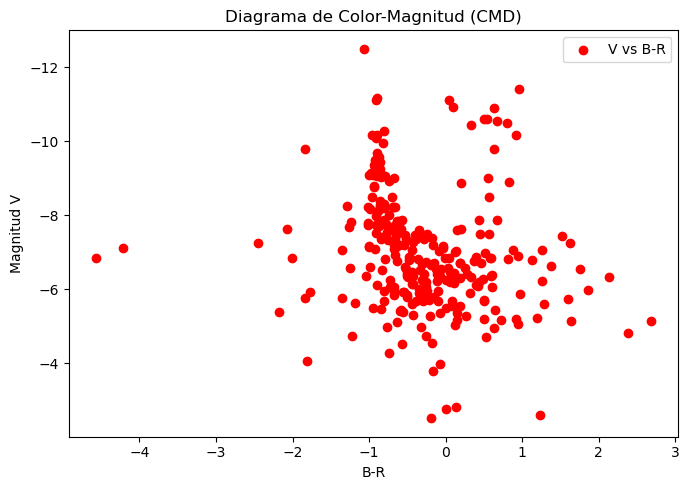

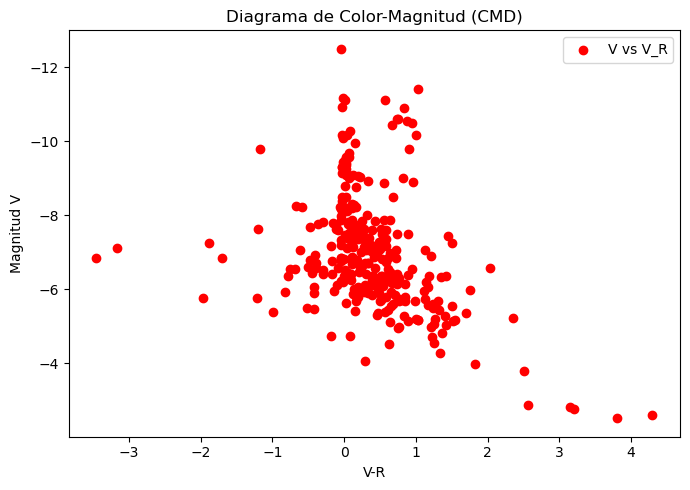

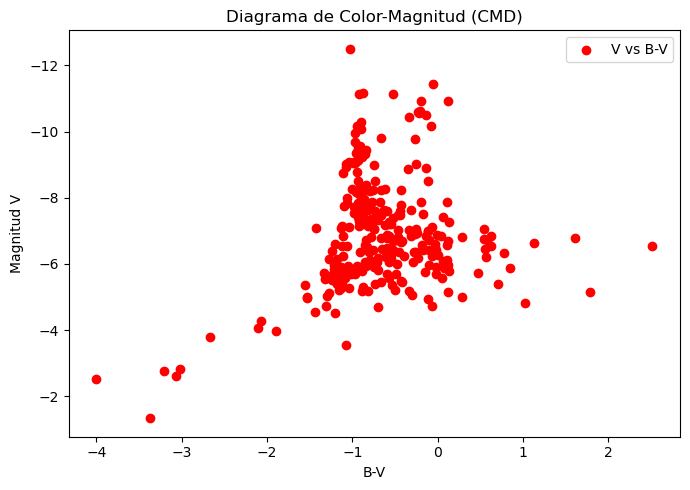

In [34]:
#Gráficos magnitud color CMD:
color_bv = [color(m1, m2) for m1, m2 in zip(magnitudes_azul_final, magnitudes_verde_final)]
color_vr = [color(m1, m2) for m1, m2 in zip(magnitudes_verde_final, magnitudes_rojo_final)]
color_br = [color(m1, m2) for m1, m2 in zip(magnitudes_azul_final, magnitudes_rojo_final)]
v = magnitudes_verde_final
b = magnitudes_azul_final
r = magnitudes_rojo_final

plt.figure(figsize=(7, 5))
plt.scatter(color_br, v, color='red', label='V vs B-R')
plt.xlabel('B-R')
plt.ylabel('Magnitud V')
plt.gca().invert_yaxis()
plt.title('Diagrama de Color-Magnitud (CMD)')
plt.legend()
plt.tight_layout()
plt.savefig('CMD_BR.png')

plt.figure(figsize=(7, 5))
plt.scatter(color_vr, v, color='red', label='V vs V_R')
plt.xlabel('V-R')
plt.ylabel('Magnitud V')
plt.gca().invert_yaxis()
plt.title('Diagrama de Color-Magnitud (CMD)')
plt.legend()
plt.tight_layout()
plt.savefig('CMD_VR.png')

plt.figure(figsize=(7, 5))
plt.scatter(color_bv, v, color='red', label='V vs B-V')
plt.xlabel('B-V')
plt.ylabel('Magnitud V')
plt.gca().invert_yaxis()
plt.title('Diagrama de Color-Magnitud (CMD)')
plt.legend()
plt.tight_layout()
plt.savefig('CMD_BV.png')